# Inventory Optimization with Reinforcement Learning

**Done by: Sebastian Sarasti**

## Problem Statement

What is inventory optimization really?

Inventory optimization involves developing machine learning models to forecast future demand and manage stock levels effectively. The ultimate goal is to build a resilient and proactive supply chain, rather than one that simply reacts to disruptions.

Broadly, inventory optimization relies on two types of models:

1. Forecasting Models – These predict future demand using methods like Prophet, ARIMA, or other time series algorithms.
2. Reordering Models – These determine optimal production or restocking strategies based on demand forecasts, often leveraging linear models or reinforcement learning.

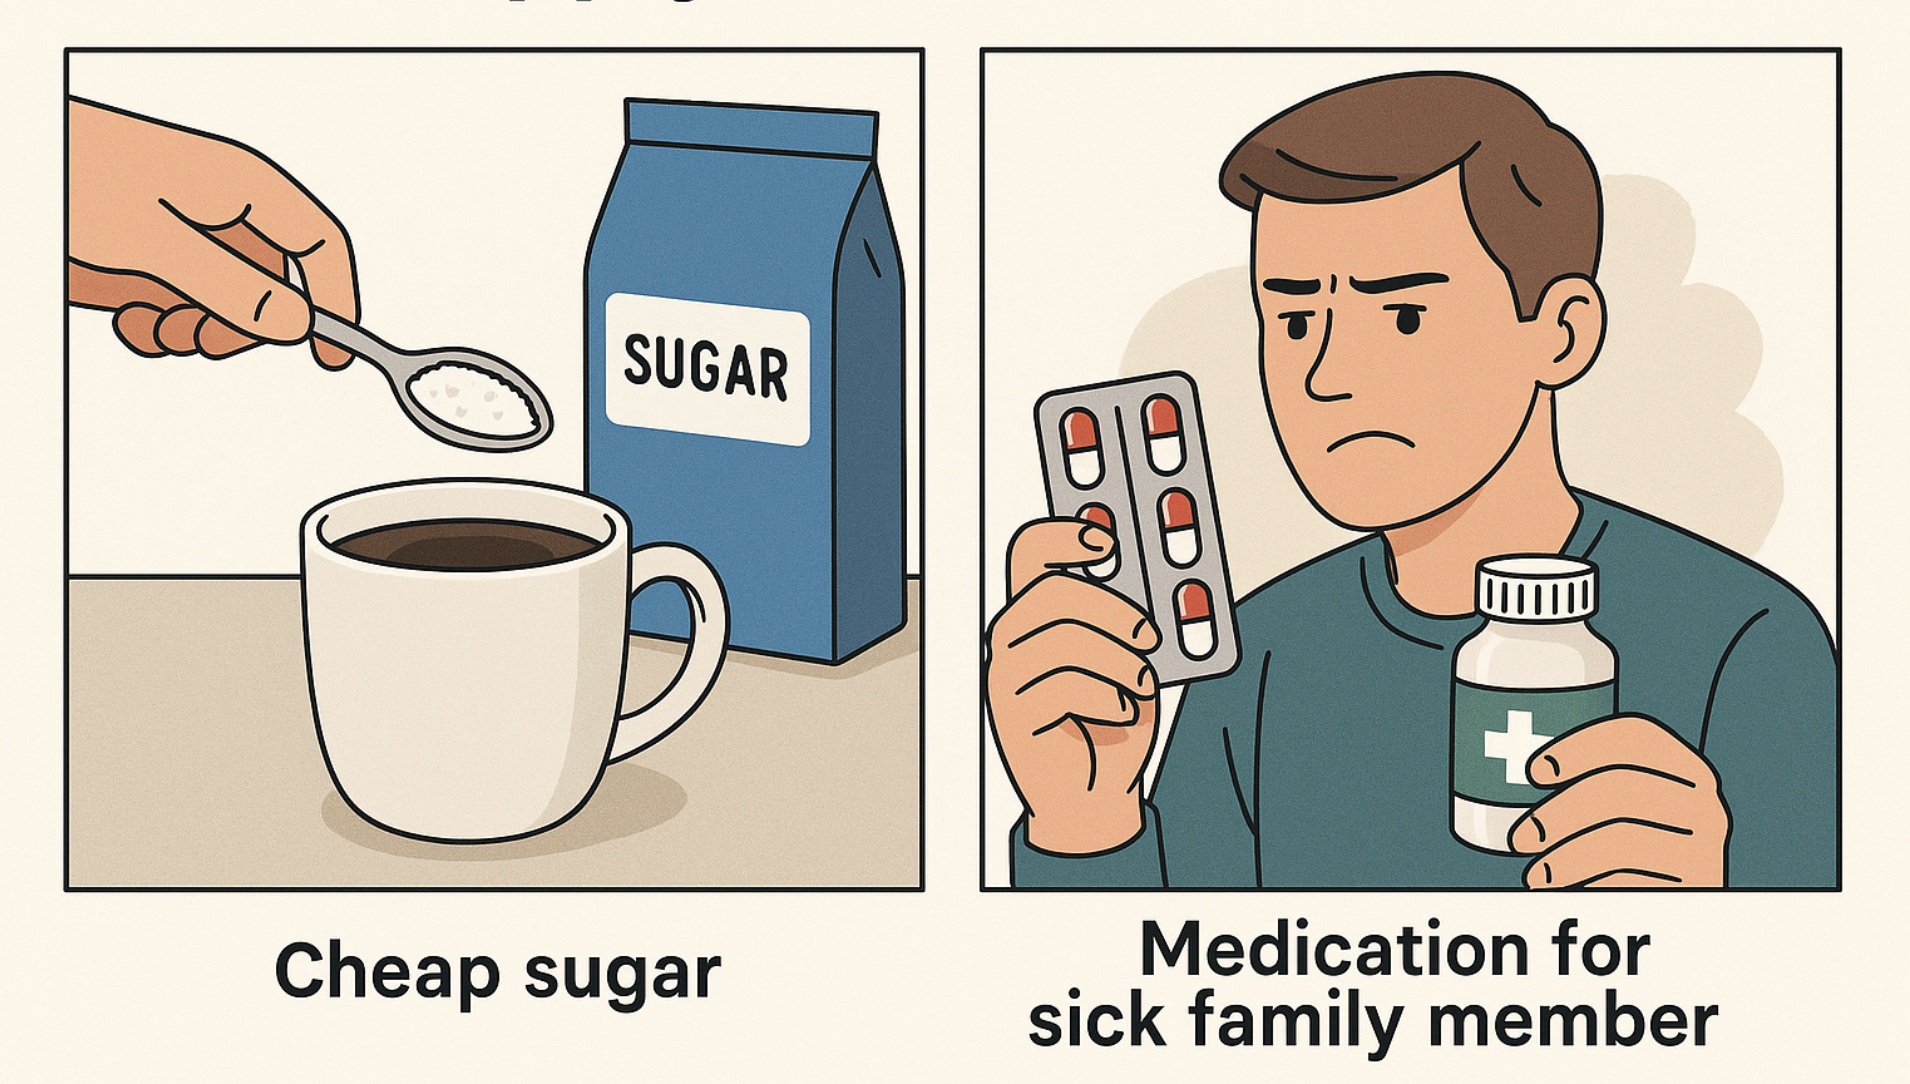

**Main Advantage**

In this notebook, we will focus on modeling the reorder process. In this case, you will see how you can create a model based on reinforcement learning in just few lines of code as other popular ML Frameworks.

## Modeling

Import basic libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RLInventoryOpt.qlearning import QLearningOptimizer

Define a seed generator

In [20]:
np.random.seed(99)

Problem statement:

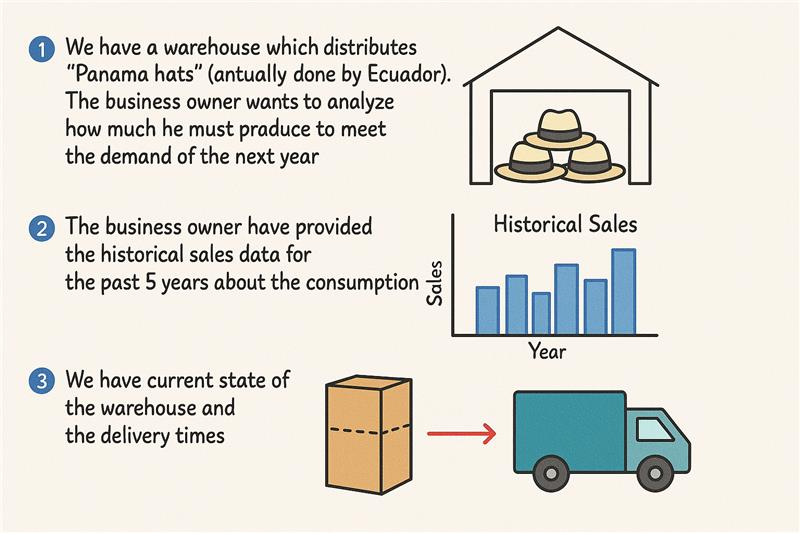

### Forecasting

In [3]:
# Define the start and end dates
start_date = "2019-01-01"
end_date = "2024-12-31"

# Create a date range with a monthly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq="ME")

# Generate a random demand for each date in the date range
demand = np.random.randint(low=100, high=1000, size=len(date_range))

# Create a DataFrame with the date range and demand
df = pd.DataFrame({"date": date_range, "demand": demand})

Let's explore the fake data

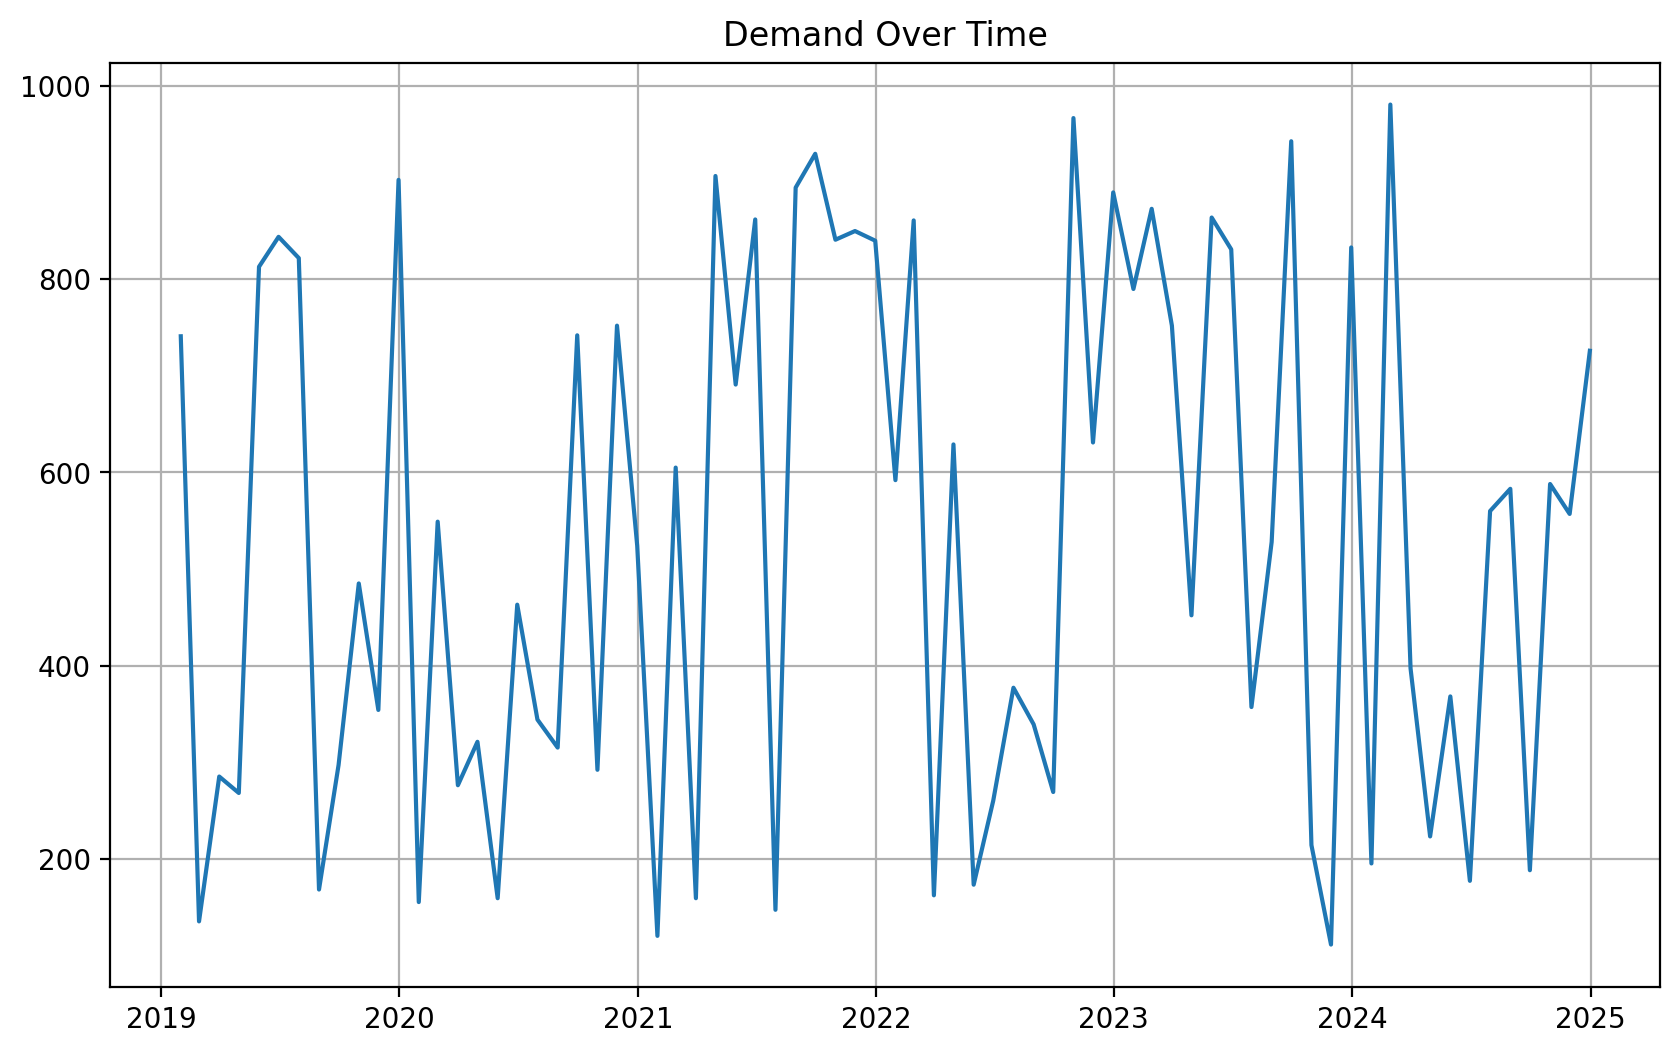

In [4]:
plt.figure(figsize=(10, 6), dpi=200)
plt.title("Demand Over Time")
plt.plot(df["date"], df["demand"])
plt.grid()
plt.show()

In [5]:
from prophet import Prophet

/opt/anaconda3/envs/conf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = df.rename(columns={"date": "ds", "demand": "y"})

In [7]:
model1 = Prophet()
model1.fit(df)

20:12:43 - cmdstanpy - INFO - Chain [1] start processing
20:12:43 - cmdstanpy - INFO - Chain [1] done processing


Make a prediction for the next year

In [8]:
n_months = 12
future = model1.make_future_dataframe(periods=n_months, freq="M")
forecast = model1.predict(future)[["ds", "yhat"]].tail(n_months)

/opt/anaconda3/envs/conf/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


See the forecast and the historical data

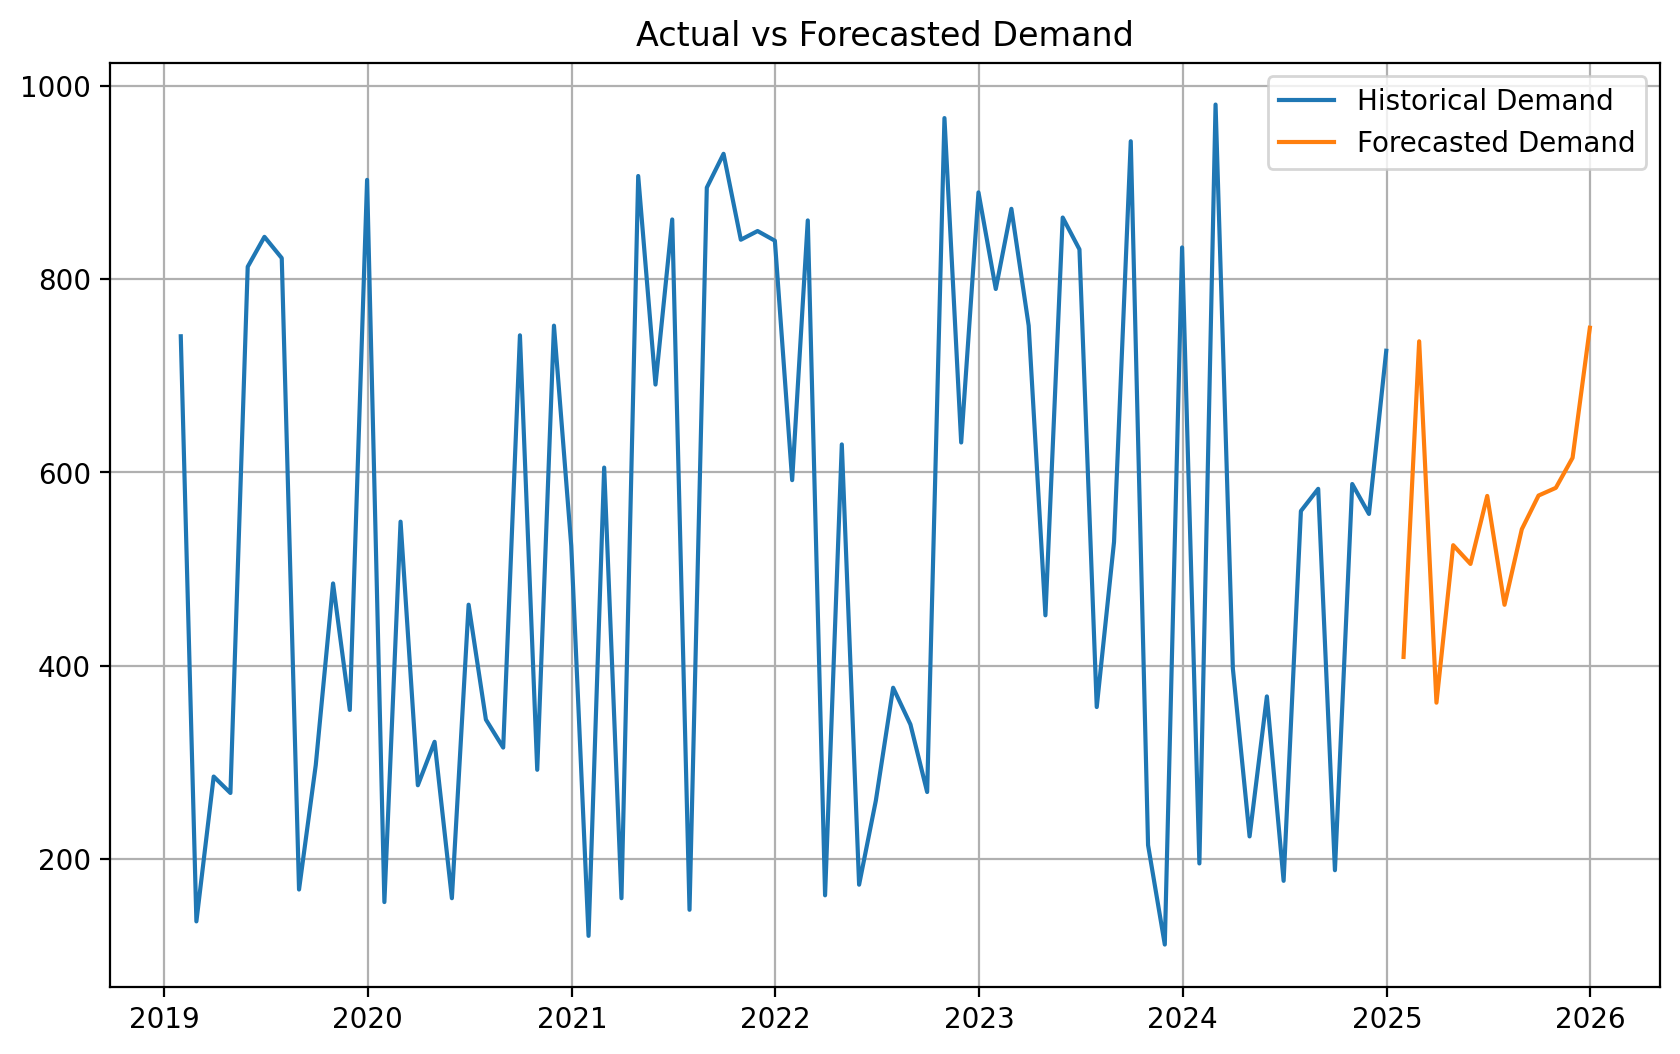

In [21]:
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(df["ds"], df["y"], label="Historical Demand")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecasted Demand")
plt.grid()
plt.legend()
plt.title("Actual vs Forecasted Demand")
plt.show()

## Reordering (Inventory Optimization)

### RL Deep Dive

Before discussing the modeling, what is reinforcement learning?

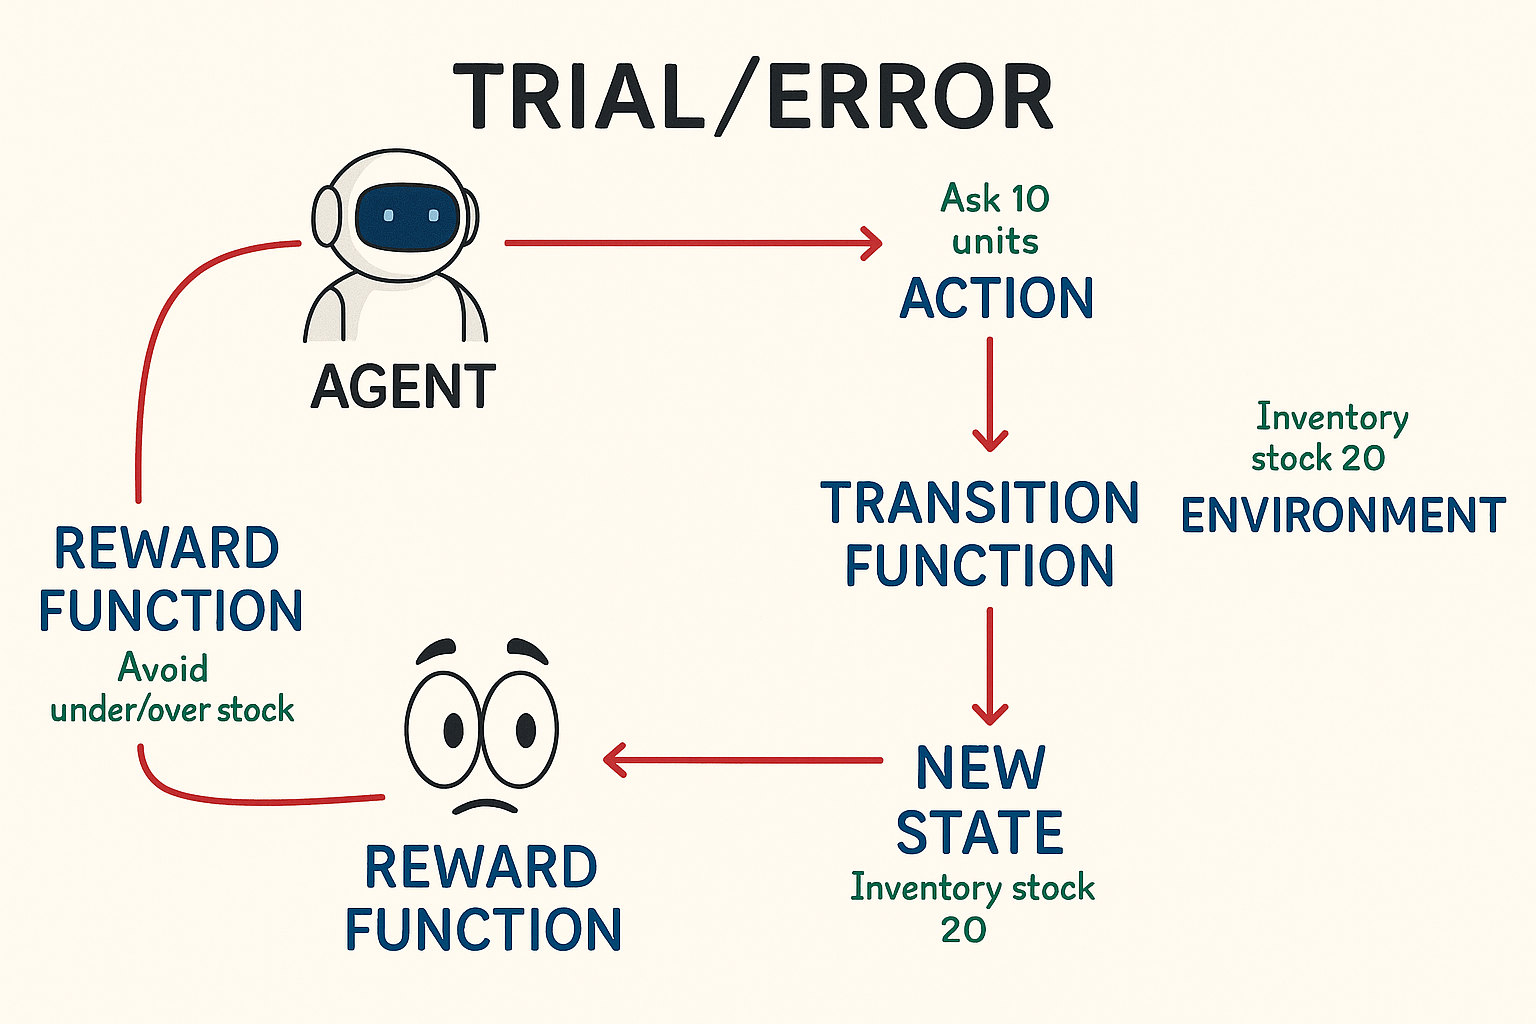

**Temporal Credit Assigment**

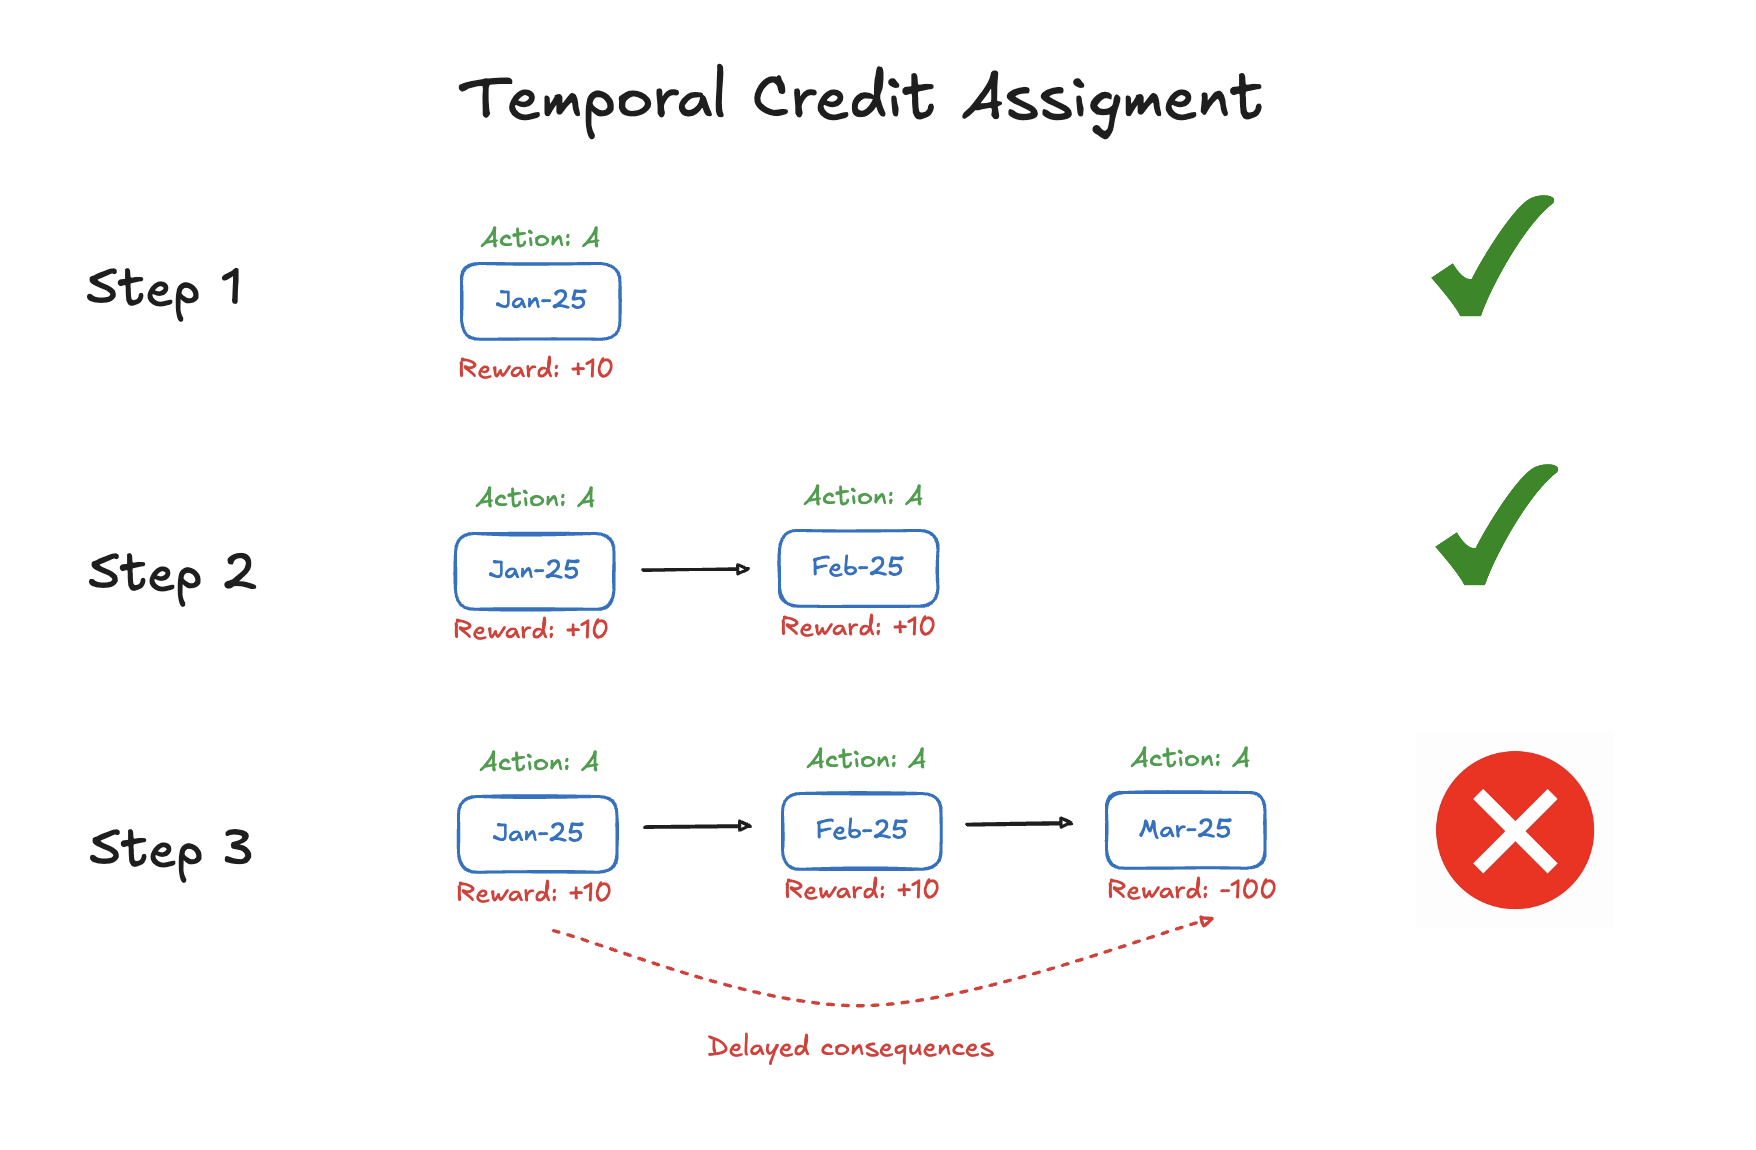

How to apply RL in the Inventory Optimization:

**Assumptions:** 
1. Consider we have a beggining and end. 
2. Do not model the environment, and considered a value-based function RL problem. 
3. Make a way to balance between the current and future states. 

### Q-Learning algorithm

Q-learning algorithm is a model-free RL approach, in this case, it is evaluated for each possible state the actions that can be taken. The actions executed at the end are the summary of the best actions for each state. 

Example:

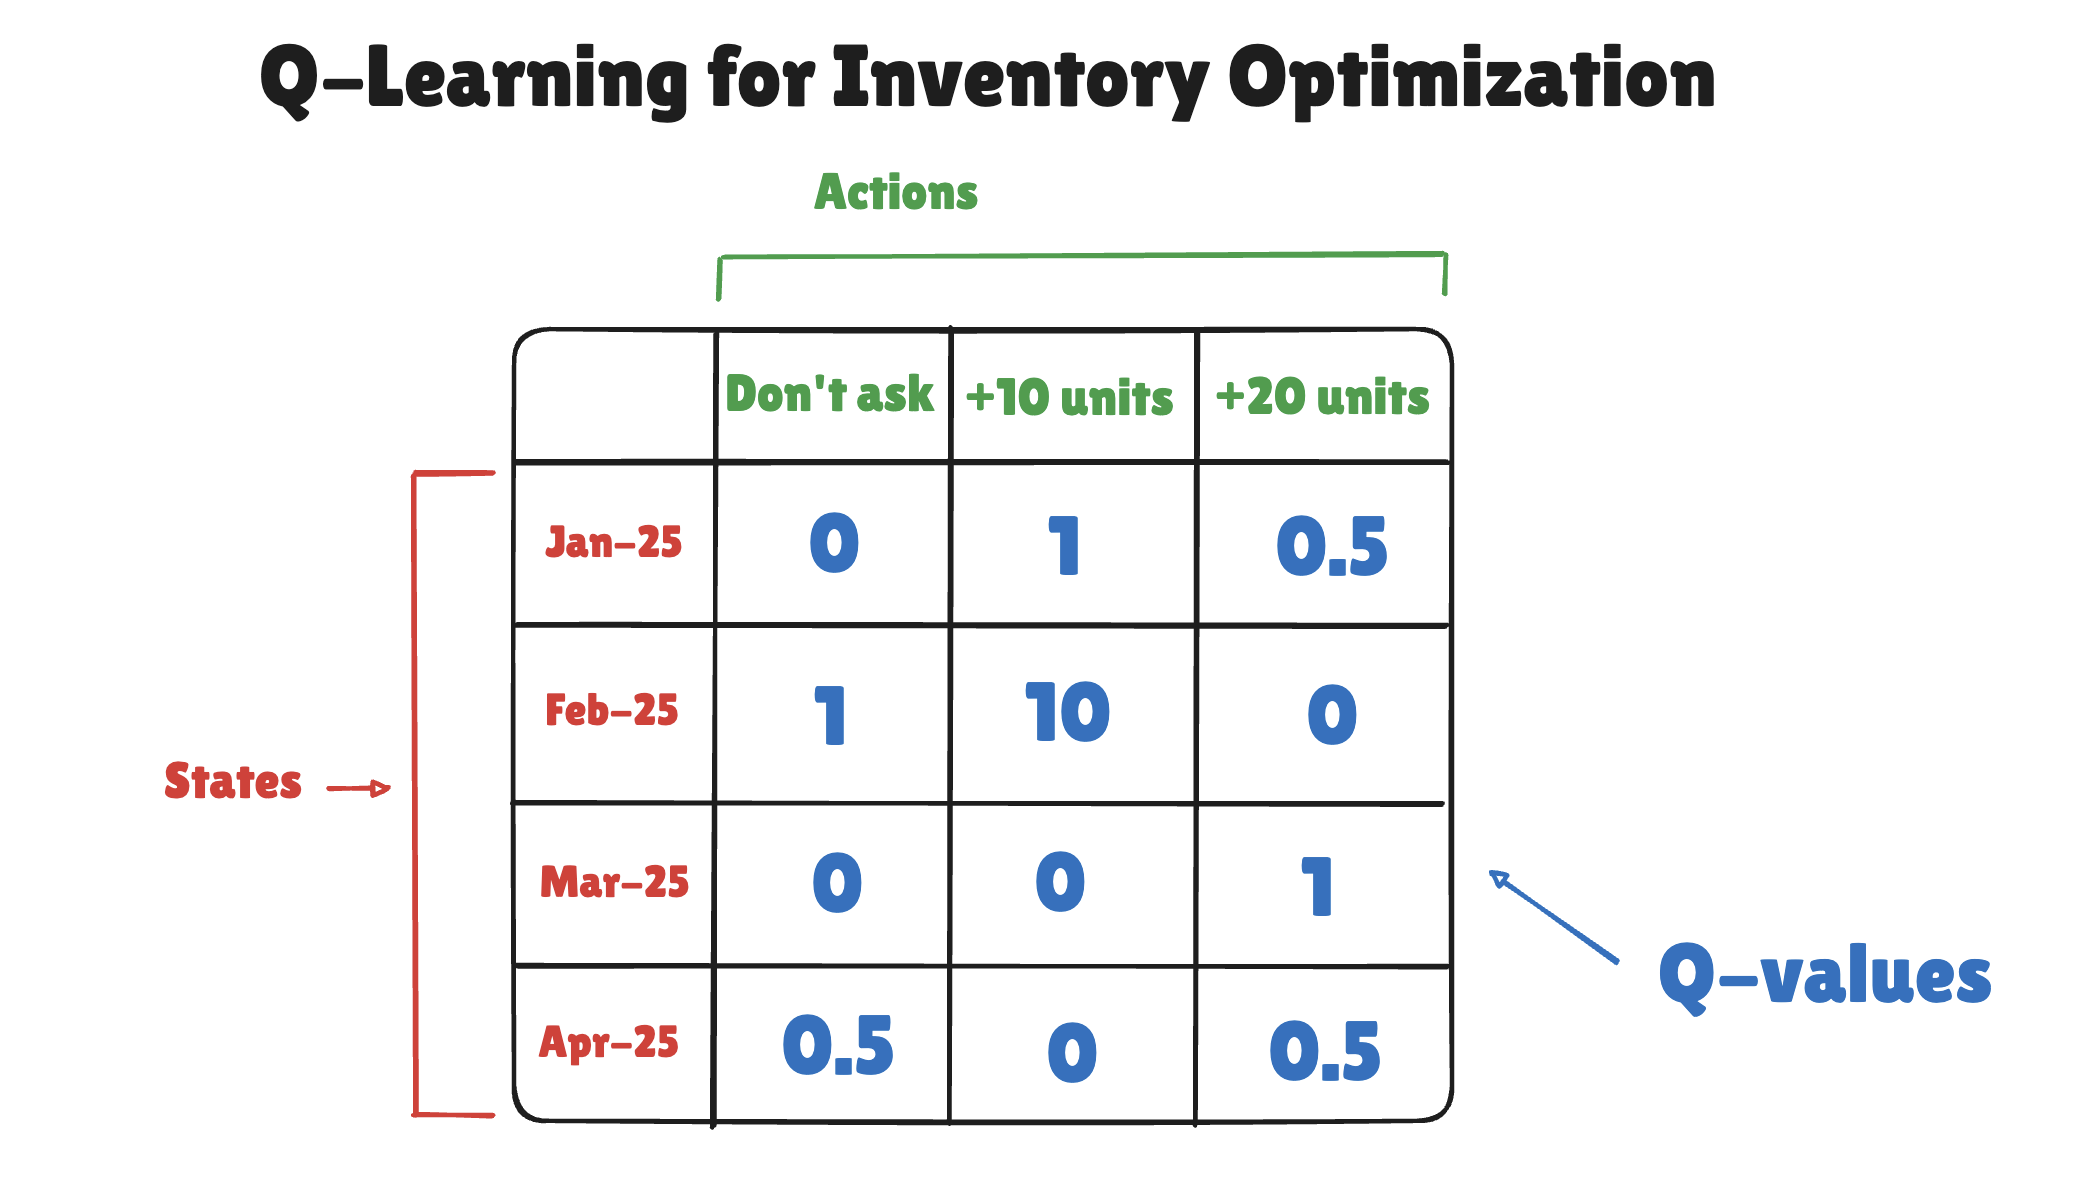

**Training loop**

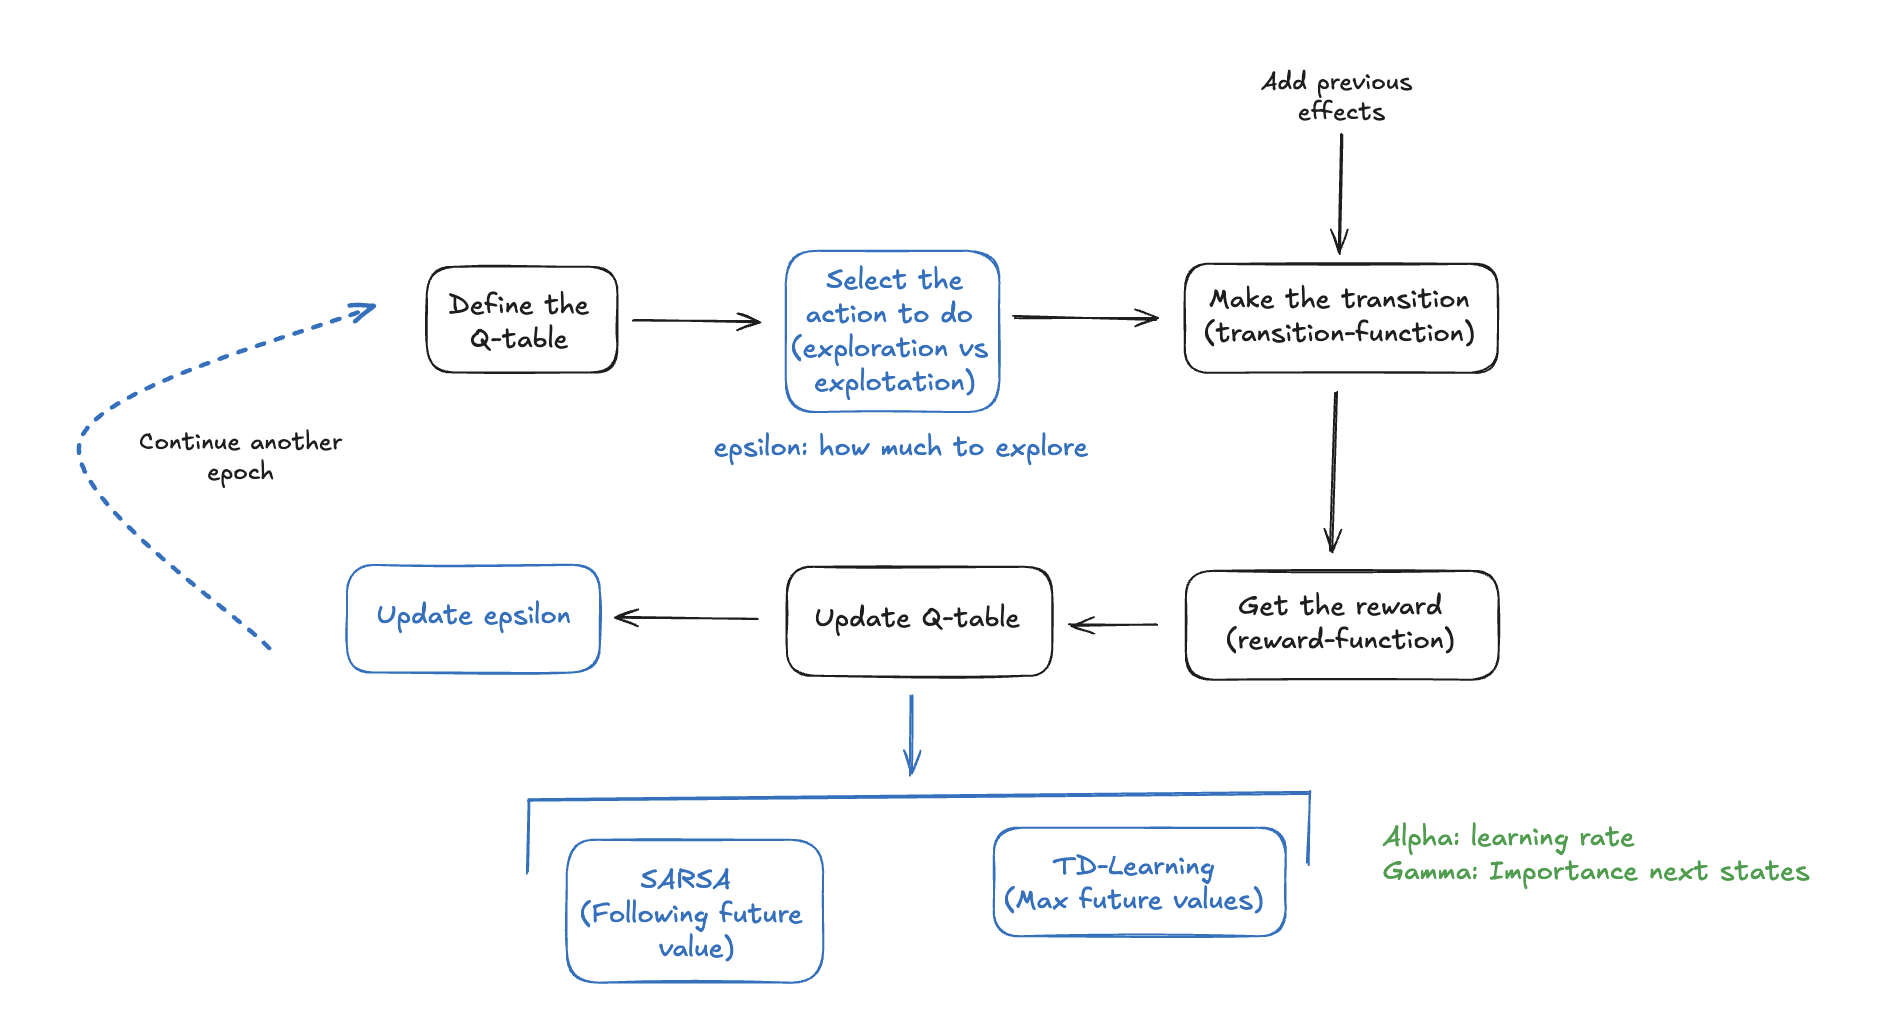

### RLInventoryOpt modeling

Well, but, what are the conditions to iterate over the inventory?

1. **Initial stock:** how many items do we have available for the time $t$.
2. **Lead-time:** the time required to arrive new units.
3. **Minimum Order:** the minimum amount of items to ask to our providers. Sometimes, we need to ask above a defined units because of contract definitions.
4. **Maximum Capacity:** this is the physical constrain of the warehouse. You cannot have more items because you have no space.

In [10]:
initial_state = {
    "stock": 1500,
    "leadTime": 2,
    "minimumOrder": 20,
    "securityStock": 100,
    "maximalCapacity": 3000,
}

In addition to the previous conditions, we need to define the actions that our agent can do:

In [11]:
actions = [
    "no",
    "m",
    "2m",
    "5m",
    "9m",
    "15m",
    "20m",
    "30m",
    "40m",
    "50m",
    "80m",
    "70m",
    "100m",
]

Define the model

In [12]:
model = QLearningOptimizer(
    forecast=np.round(forecast["yhat"].values, 0),
    initial_stock=initial_state["stock"],
    security_stock=initial_state["securityStock"],
    capacity=initial_state["maximalCapacity"],
    n_actions=actions,
    min_order=initial_state["minimumOrder"],
    lead_time=initial_state["leadTime"],
    alpha=0.9,
    gamma=0.7,
    epsilon=0.5,
)

Train the model

In [13]:
model.fit(epochs=10000)

In [14]:
df_pred = pd.DataFrame(model.q_table, columns=model.raw_actions)
df_pred["actions"] = df_pred.idxmax(axis=1)

Make the predictions

In [15]:
predictions = model.predict()

In [16]:
model.plot("bar")

## Summary

- Forecasting done (model 1) + Reordering (model 2 - reinforcement learning)
- Inventory without over/under stocking.
- Non-linear pattern
- No negative values
- Considered the influence of long-term rewards.

![tarjeta de presentacio.png](<attachment:tarjeta de presentacio.png>)
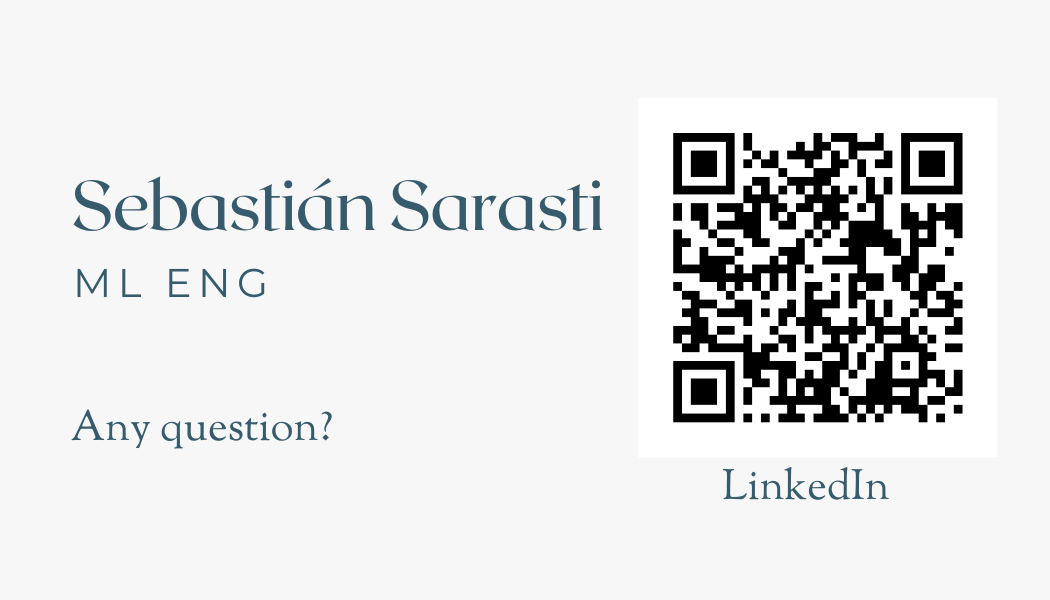

The library [LINK](https://github.com/sebassaras02/rf_inventory_optimization/tree/master)

A medium articule [LINK](https://medium.com/@sebitas.alejo/reinforcement-learning-for-inventory-optimization-f63c26a59c19)